<a href="https://colab.research.google.com/github/mapaloCat/Traffic-Sign-Detection-System/blob/master/02_train_binary_detector_TL_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The German Traffic Sign Benchmark - Data Preparation

Collaborator 1: Panagiotis Michalopoulos

Collaborator 2: Filip Finfando

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!wget -c https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2020-03-05 18:02:57--  https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  25.3MB/s    in 63s     

2020-03-05 18:04:02 (25.0 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN2013/00009.

In [3]:
# use those numbers to change range in the next cell
! wc -l 'drive/My Drive/data/bin_labels_sorted.txt'
! grep "00600.ppm" -B 5 -A 5 -m 1 'drive/My Drive/data/bin_labels_sorted.txt' --line-number

20554 drive/My Drive/data/bin_labels_sorted.txt
13566-00599.ppm;823;393;861;416;-1
13567-00599.ppm;827;392;848;413;-1
13568-00599.ppm;879;342;935;393;-1
13569-00599.ppm;922;336;954;359;-1
13570-00599.ppm;961;328;1011;391;-1
13571:00600.ppm;105;425;139;453;-1
13572-00600.ppm;116;435;154;472;-1
13573-00600.ppm;12;426;71;496;-1
13574-00600.ppm;124;422;148;456;-1
13575-00600.ppm;1;423;97;512;-1
13576-00600.ppm;151;459;183;479;-1


In [0]:
number_of_samples = 20554 
split_at = 13570

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (96, 96)

# Function for reading the images
def readImages(rootpath, images_range, signs_range, datapath, scaled):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        # image_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        # # equalize the histogram of the Y channel
        # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        # image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])
        # # convert the YUV image back to RGB format
        # img = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(datapath, delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        if scaled:
          scale = 1
        else:
          scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,split_at), 'drive/My Drive/data/bin_labels_sorted.txt', True)
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(split_at,number_of_samples), 'drive/My Drive/data/bin_labels_sorted.txt', True)

In [0]:
# noise_boxes_to_include = 13000

# ind_noise = [i for i, e in enumerate(train_labels) if e=='-1']
# print(len(ind_noise))
# ind_signs = [i for i, e in enumerate(train_labels) if e!='-1']
# print(len(ind_signs))
# rs = np.append(np.random.choice(ind_noise, noise_boxes_to_include), ind_signs)
# # print(len(rs))
# # print(type(rs))
# # print(rs)

# train_files = [train_files[j] for j in rs]
# train_signs = [train_signs[j] for j in rs]
# train_bboxes = [train_bboxes[j] for j in rs]
# train_labels = [train_labels[j] for j in rs]

In [0]:
# ind_zeros = [i for i, e in enumerate(test_labels) if e=='0']
# print(len(ind_zeros))
# ind_ones = [i for i, e in enumerate(test_labels) if e=='1']
# print(len(ind_ones))
# # print(type(ind_zeros))
# # print(len(train_labels))
# # print(len(ind_zeros))
# # print(ind_zeros)
# rs = np.append(np.random.choice(ind_zeros, len(ind_ones)), ind_ones)
# # print(len(rs))
# # print(type(rs))
# # print(rs)

# test_files = [test_files[j] for j in rs]
# test_signs = [test_signs[j] for j in rs]
# test_bboxes = [test_bboxes[j] for j in rs]
# test_labels = [test_labels[j] for j in rs]

['-1' '0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20'
 '21' '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34'
 '35' '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
[[   -1     0     1     2     3     4     5     6     7     8     9    10
     11    12    13    14    15    16    17    18    19    20    21    22
     23    24    25    26    27    28    29    30    31    32    33    34
     35    36    37    38    39    40    41    42]
 [11719    10    99   134    48    68    89    44    94   101    73   139
     58   113   111    50    22    18    49    50     6    19     8    21
     30     2    47    24     8    18     8    33     2     6    27    18
     30    13     2   113     8    14    12    12]]


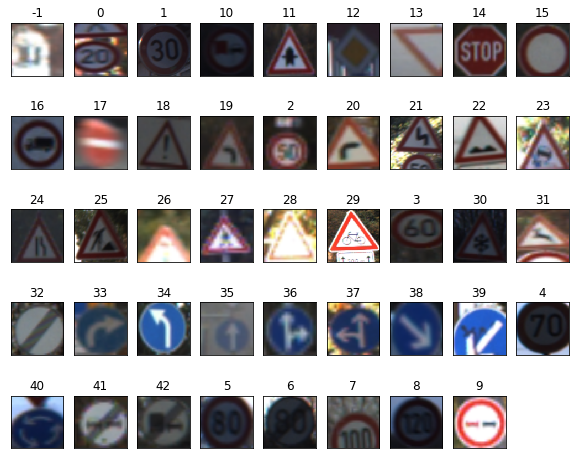

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
print(class_names)

ue, ce = np.unique(np.array(train_labels).astype('int32'), return_counts = True)
print(np.asarray((ue, ce)))

for r in range(1):
    fig = plt.figure(figsize=(10,10))
    for i in range(num_classes):
        ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
        ax.set_title(class_names[i])
        indices = np.where(np.isin(train_labels, class_names[i]))[0]
        plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
    plt.show()

In [0]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)

## Data Augmentation

In [0]:
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform

def rotate_image(image, max_angle =10):
    rotate_out = rotate(image, np.random.uniform(-max_angle, max_angle), mode='edge')
    return rotate_out

def translate_image(image, max_trans = 5, height=96, width=96):
    translate_x = max_trans*np.random.uniform() - max_trans/2
    translate_y = max_trans*np.random.uniform() - max_trans/2
    translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
    trans = cv2.warpAffine(image, translation_mat, (height,width))
    return trans
    
def projection_transform(image, max_warp=0.8, height=96, width=96):
    #Warp Location
    d = height * 0.3 * np.random.uniform(0,max_warp)
    
    #Warp co-ordinates
    tl_top = np.random.uniform(-d, d)     # Top left corner, top margin
    tl_left = np.random.uniform(-d, d)    # Top left corner, left margin
    bl_bottom = np.random.uniform(-d, d)  # Bottom left corner, bottom margin
    bl_left = np.random.uniform(-d, d)    # Bottom left corner, left margin
    tr_top = np.random.uniform(-d, d)     # Top right corner, top margin
    tr_right = np.random.uniform(-d, d)   # Top right corner, right margin
    br_bottom = np.random.uniform(-d, d)  # Bottom right corner, bottom margin
    br_right = np.random.uniform(-d, d)   # Bottom right corner, right margin
        
    ##Apply Projection
    transform = ProjectiveTransform()
    transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, height - bl_bottom),
                (height - br_right, height - br_bottom),
                (height - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, height),
                (height, height),
                (height, 0)
            )))
    output_image = warp(image, transform, output_shape=(height, width), order = 1, mode = 'edge')
    return output_image
    

def transform_image(image, max_angle=10, max_trans=5 ,max_warp=0.8):
    ## Simple pipline to take an input image and apply a serise of simple
    ## Distortions to augment the training data set
    ## (note: this function will rescale pixel values between 0-1)
    ##
    height, width, channels = image.shape
    #Rotate Image
    rotated_image = rotate_image(image, max_angle)
    #Translate Image
    translated_image = translate_image(rotated_image, max_trans, height, width)
    #Project Image
    output_image = projection_transform(translated_image, max_warp, height, width)
    return (output_image*255.0).astype(np.uint8)

    
def augment_and_balance_data(X_train, y_train, no_examples_per_class):
    
    n_examples = no_examples_per_class
    #Get paramters of data
    classes, class_indices, class_counts  = np.unique(y_train, return_index=True, return_counts=True)
    n_classes = len(class_counts)
    #print(n_classes)
    height, width, channels = X_train[0].shape
    
    
    #Create new data and labels for the balanced augmented data
    X_balance = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
    y_balance = np.empty([0], dtype = np.int32)
    

    #for c, count in zip(range(n_classes), class_counts):
    for c, count in zip(classes.astype(int), class_counts):
      ##Copy over the current data for the given class
      X_orig = X_train[y_train == c]
      #print(X_orig.shape)
      y_orig = y_train[y_train == c]
      #print(y_orig.shape)
      ##Add original data to the new dataset
      X_balance = np.append(X_balance, X_orig, axis=0)
      print(c,count)
      
      # if count >= no_examples_per_class:
      #   temp_X = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
      # else:
      #   temp_X = np.empty([n_examples-count, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
      #   #print(n_examples-count)
      #   for i in range(n_examples - count):
      #     #print(i%count)
      #     temp_X[i,:,:,:] = transform_image(X_orig[i%count]).reshape((1, height, width, channels)) 

      temp_X = np.empty([n_examples, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
      for i in range(n_examples):
        temp_X[i,:,:,:] = transform_image(X_orig[i%count]).reshape((1, height, width, channels))      
          
          
      X_balance = np.append(X_balance,temp_X, axis=0)
      n_added_ex = X_balance.shape[0] - y_balance.shape[0]
      y_balance = np.append(y_balance, np.full(n_added_ex, c, dtype =np.int32))
        
   
    return X_balance.astype(np.uint8), y_balance

[[   -1     0     1     2     3     4     5     6     7     8     9    10
     11    12    13    14    15    16    17    18    19    20    21    22
     23    24    25    26    27    28    29    30    31    32    33    34
     35    36    37    38    39    40    41    42]
 [11719    10    99   134    48    68    89    44    94   101    73   139
     58   113   111    50    22    18    49    50     6    19     8    21
     30     2    47    24     8    18     8    33     2     6    27    18
     30    13     2   113     8    14    12    12]]


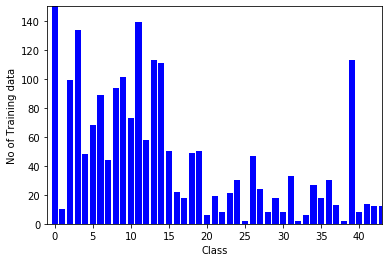

 
We can definitely see class bias issue as certain classes are under represented


In [10]:
# Checking for class bias before data augmentation 

unique_elements, counts_elements = np.unique(np.array(train_labels).astype('int32'), return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 44 ), counts_elements, align='center',color='blue' )
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 43])
plt.ylim([0, 150])

plt.show()

print(" ")
print("We can definitely see class bias issue as certain classes are under represented")

[[  -1    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   22   23   24   25   26   28   29   30   31
    32   33   34   35   36   37   38   39   40   41   42]
 [6163   78   50   23   84   34    5   13   25   21   34   27   69   74
    25   11    2   10   22    8   19    7   18   14   13    4    4    3
    12    6    7   10    2    3   64    3    6    2    9]]


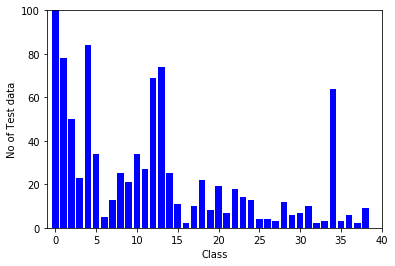

 
We can definitely see class bias issue as certain classes are under represented


In [11]:
# Checking for class bias in test set

unique_elements, counts_elements = np.unique(np.array(test_labels).astype('int32'), return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 39 ), counts_elements, align='center',color='blue' )
plt.xlabel('Class')
plt.ylabel('No of Test data')
plt.xlim([-1, 40])
plt.ylim([0, 100])

plt.show()

print(" ")
print("We can definitely see class bias issue as certain classes are under represented")

In [12]:
no_examples_per_class = 100
X_train_aug, y_train_aug = augment_and_balance_data(np.array(train_signs), np.array(train_labels).astype('int32'), no_examples_per_class)
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)

-1 11719
0 10
1 99
2 134
3 48
4 68
5 89
6 44
7 94
8 101
9 73
10 139
11 58
12 113
13 111
14 50
15 22
16 18
17 49
18 50
19 6
20 19
21 8
22 21
23 30
24 2
25 47
26 24
27 8
28 18
29 8
30 33
31 2
32 6
33 27
34 18
35 30
36 13
37 2
38 113
39 8
40 14
41 12
42 12


[[   -1     0     1     2     3     4     5     6     7     8     9    10
     11    12    13    14    15    16    17    18    19    20    21    22
     23    24    25    26    27    28    29    30    31    32    33    34
     35    36    37    38    39    40    41    42]
 [11819   110   199   234   148   168   189   144   194   201   173   239
    158   213   211   150   122   118   149   150   106   119   108   121
    130   102   147   124   108   118   108   133   102   106   127   118
    130   113   102   213   108   114   112   112]]


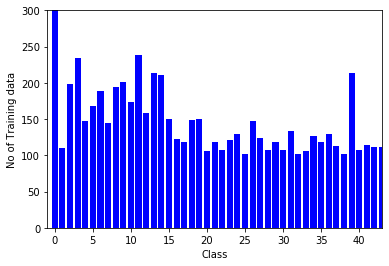

In [13]:
# Checking for class bias after data augmentation

unique_elements, counts_elements = np.unique(y_train_aug, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 44 ), counts_elements, align='center',color='blue' )
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 43])
plt.ylim([0, 300])

plt.show()

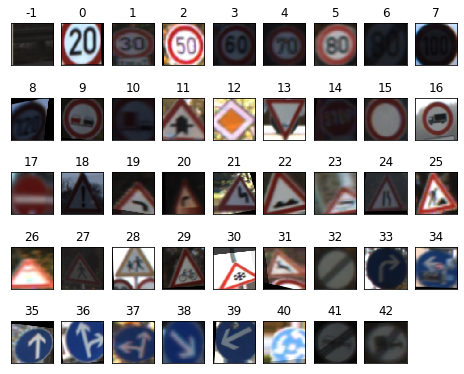

In [14]:
# Show examples from each class after data augmentation
class_names = np.unique(y_train_aug)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(y_train_aug, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(X_train_aug[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
# import collections

# idxp = np.where(y_train_aug != -1)
# idxn = np.where(y_train_aug == -1)
# y_train_aug[idxn[0]] = 0
# y_train_aug[idxp[0]] = 1

# print(collections.Counter(y_train_aug))

# idxp = [i for i,x in enumerate(test_labels) if x != '-1']
# idxn = [i for i,x in enumerate(test_labels) if x == '-1']
# test_labels = np.array(test_labels)
# test_labels[np.array(idxn).astype('int')] = 0
# test_labels[np.array(idxp).astype('int')] = 1

# print(collections.Counter(test_labels))

In [15]:
num_classes = 44
print("num_classes: ", num_classes)

num_classes:  44


In [0]:
from sklearn.model_selection import train_test_split

tr_signs, va_signs, tr_labels, va_labels = train_test_split(X_train_aug, y_train_aug, test_size=0.2, random_state=42, stratify=y_train_aug)

In [0]:
tr_signs = np.array(tr_signs)
tr_labels = np.array(tr_labels)
va_signs = np.array(va_signs)
va_labels = np.array(va_labels)
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

temp_tr_labels = tr_labels

In [18]:
from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Training - Xception

In [21]:
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam

baseline = Xception(weights='imagenet', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), include_top=False)

x = baseline.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
# x = Dense(1024, use_bias=False)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)

# x = Dense(2048, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)

predictions = Dense(num_classes, activation='softmax')(x)
tlm = Model(inputs=baseline.input, outputs=predictions)

# for i,layer in enumerate(tlm.layers):
#   print(i,layer.name)  

# print('\nnon-trainable')
# for layer in baseline.layers[:116]:
#     layer.trainable=False
#     print(layer.name)

# print('\ntrainable')
# for layer in baseline.layers[116:]:
#     layer.trainable=True
#     print(layer.name)

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
tlm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
tlm.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 47, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [22]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight("balanced", np.unique(temp_tr_labels), temp_tr_labels)

# class_weights[0] = 1
# class_weights[1] = 100

print(class_weights)

[0.03455603 3.71280992 2.05488851 1.74720467 2.74560733 2.43826323
 2.16375677 2.84110672 2.10791789 2.02936194 2.36758893 1.71061399
 2.59307359 1.92192513 1.93329747 2.72272727 3.33395176 3.47582205
 2.74560733 2.72272727 3.84385027 3.43923445 3.75548589 3.3683224
 3.14160839 3.98447894 2.76887519 3.30027548 3.79915433 3.43923445
 3.75548589 3.08233276 3.98447894 3.84385027 3.20320856 3.47582205
 3.14160839 3.63030303 3.98447894 1.92192513 3.79915433 3.59040959
 3.63030303 3.63030303]


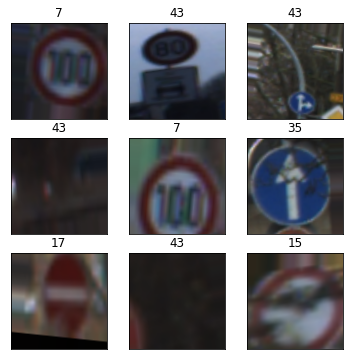




Epoch 1/100
 - 63s - loss: 0.9398 - acc: 0.7706 - val_loss: 0.5435 - val_acc: 0.8450

Epoch 2/100
 - 49s - loss: 0.3256 - acc: 0.9076 - val_loss: 0.1942 - val_acc: 0.9374
Epoch 3/100
 - 49s - loss: 0.2217 - acc: 0.9432 - val_loss: 0.1907 - val_acc: 0.9535
Epoch 4/100
 - 49s - loss: 0.1283 - acc: 0.9673 - val_loss: 0.0691 - val_acc: 0.9836
Epoch 5/100
 - 49s - loss: 0.0854 - acc: 0.9783 - val_loss: 0.0673 - val_acc: 0.9833
Epoch 6/100
 - 49s - loss: 0.1048 - acc: 0.9782 - val_loss: 0.1386 - val_acc: 0.9702
Epoch 7/100
 - 49s - loss: 0.1222 - acc: 0.9735 - val_loss: 0.3942 - val_acc: 0.9082
Epoch 8/100
 - 49s - loss: 0.1244 - acc: 0.9716 - val_loss: 0.2625 - val_acc: 0.9332
Epoch 9/100
 - 49s - loss: 0.2321 - acc: 0.9552 - val_loss: 0.1813 - val_acc: 0.9594
Epoch 10/100
 - 49s - loss: 0.0812 - acc: 0.9793 - val_loss: 0.0557 - val_acc: 0.9880
Epoch 11/100
 - 49s - loss: 0.0626 - acc: 0.9861 - val_loss: 0.3307 - val_acc: 0.9666
Epoch 12/100
 - 49s - loss: 0.0918 - acc: 0.9827 - val_loss

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.15,
                             shear_range=0.15,
                             rotation_range=10.)

datagen.fit(tr_signs, augment=True)

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

train_steps = int(len(tr_signs) / batch_size)
valid_steps = int(len(va_signs) / batch_size)

data = tlm.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=batch_size),                              
                              epochs=100, 
                              steps_per_epoch=train_steps, 
                              verbose=2, 
                              validation_data=(va_signs, va_labels), 
                              validation_steps=valid_steps, 
                              callbacks=[tensorboard, early_stopping],
                              class_weight = class_weights)

start = time()
loss, acc = tlm.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('Transfer Learning model took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

## Performance plots, confusion matrix and evaluation metrics

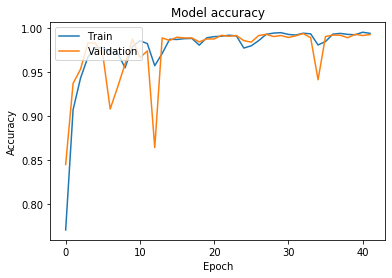

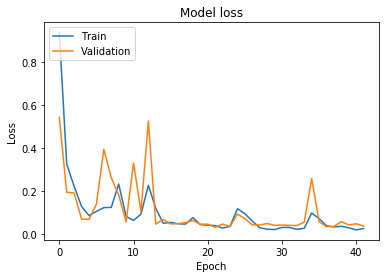

In [25]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Automatically created module for IPython interactive environment


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[9.87e-01 0.00e+00 0.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 9.60e-01 0.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 1.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 ...
 [0.00e+00 0.00e+00 0.00e+00 ... 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 ... 0.00e+00 1.00e+00 0.00e+00]
 [3.25e-04 1.62e-04 0.00e+00 ... 0.00e+00 0.00e+00 9.95e-01]]


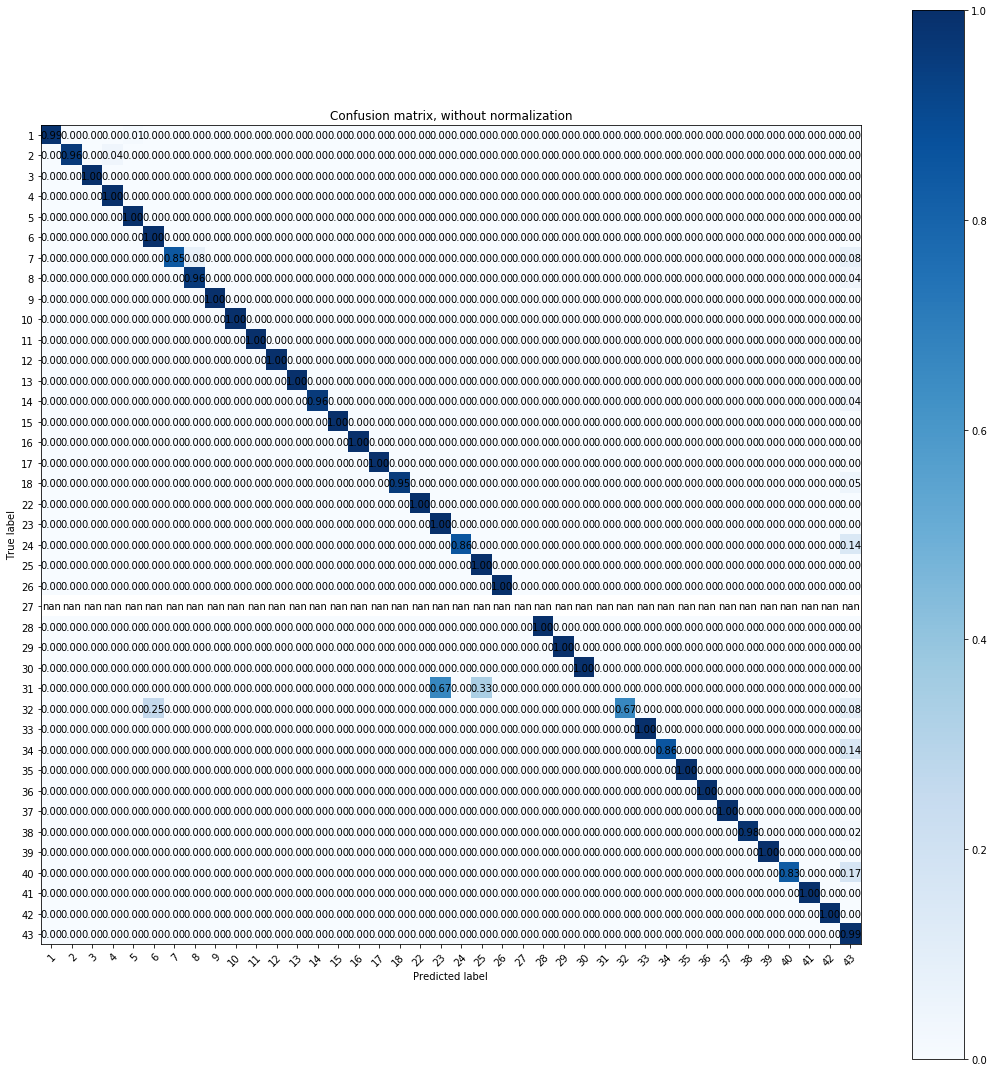

In [27]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(
    np.argmax(te_labels, axis=1), 
    np.argmax(tlm.predict(te_signs), axis=1), 
    classes=np.array(range(num_classes)),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [0]:
# from sklearn.metrics import average_precision_score, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, confusion_matrix

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(np.argmax(te_labels, axis=1), np.argmax(tlm.predict(te_signs), axis=1))
# print('Accuracy: %f' % accuracy)
# # precision tp / (tp + fp)
# precision = precision_score(np.argmax(te_labels, axis=1), np.argmax(tlm.predict(te_signs), axis=1))
# print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
# recall = recall_score(np.argmax(te_labels, axis=1), np.argmax(tlm.predict(te_signs), axis=1))
# print('Recall: %f' % recall)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(np.argmax(te_labels, axis=1), np.argmax(tlm.predict(te_signs), axis=1))
# print('F1 score: %f' % f1)
# # ROC AUC
# auc = roc_auc_score(np.argmax(te_labels, axis=1), tlm.predict(te_signs)[:,1], average="micro", multi_class="ovr")
# print('ROC AUC: %f' % auc)
# # confusion matrix
# # matrix = confusion_matrix(np.argmax(te_labels, axis=1), np.argmax(tlm.predict(te_signs), axis=1))
# # print(matrix)
# # Precision-Recall score
# average_precision = average_precision_score(np.argmax(te_labels, axis=1), np.argmax(tlm.predict(te_signs), axis=1))
# print('Average precision-recall score: {0:0.2f}'.format(average_precision))

In [0]:
# from sklearn.metrics import precision_recall_curve
# import matplotlib.pyplot as plt
# from inspect import signature

# precision, recall, _ = precision_recall_curve(np.argmax(te_labels, axis=1), te_labels_predicted)

# # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [28]:
from sklearn import metrics

print(metrics.classification_report(np.argmax(te_labels, axis=1), np.argmax(tlm.predict(te_signs), axis=1), digits=3))

              precision    recall  f1-score   support

           1      0.975     0.987     0.981        78
           2      0.980     0.960     0.970        50
           3      1.000     1.000     1.000        23
           4      0.923     1.000     0.960        84
           5      0.971     1.000     0.986        34
           6      0.455     1.000     0.625         5
           7      1.000     0.846     0.917        13
           8      0.923     0.960     0.941        25
           9      1.000     1.000     1.000        21
          10      0.971     1.000     0.986        34
          11      1.000     1.000     1.000        27
          12      0.972     1.000     0.986        69
          13      0.987     1.000     0.993        74
          14      0.889     0.960     0.923        25
          15      0.917     1.000     0.957        11
          16      1.000     1.000     1.000         2
          17      0.909     1.000     0.952        10
          18      1.000    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save model and perform some tests

In [0]:
import pickle
with open('drive/My Drive/models/test_pred.pickle', 'rb') as fp:
    test_pred = pickle.load(fp)

In [0]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('drive/My Drive/models/bin_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# tlm = model_from_json(loaded_model_json)
# # load weights into new model
# tlm.load_weights("drive/My Drive/models/bin_model.h5")
# print("Loaded binary model from disk")

In [0]:
train_images2, train_files2, train_signs2, train_bboxes2, train_labels2 = readImages('FullIJCNN2013', range(0,600), range(0,852), 'FullIJCNN2013/gt.txt', False)
test_images2, test_files2, test_signs2, test_bboxes2, test_labels2 = readImages('FullIJCNN2013', range(600,900), range(852,1213), 'FullIJCNN2013/gt.txt', False)

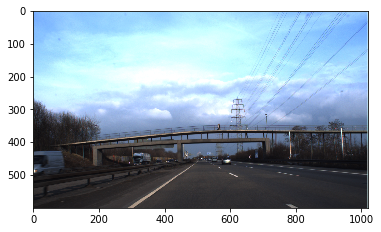

predicted sign:  7
predicted sign:  14
predicted sign:  8
ground truth sign:  7


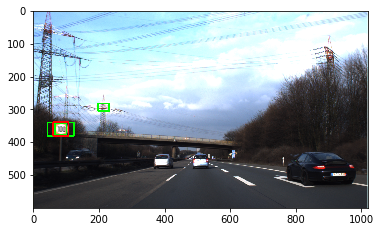

predicted sign:  8
predicted sign:  8
predicted sign:  8
ground truth sign:  8
ground truth sign:  8


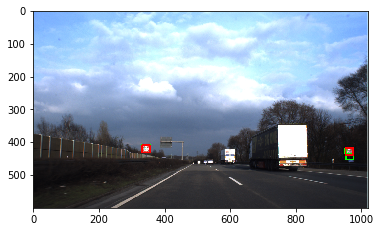

predicted sign:  10
predicted sign:  10
predicted sign:  10
ground truth sign:  10


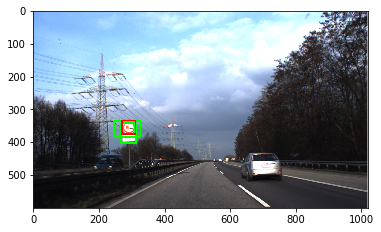

predicted sign:  30
predicted sign:  13
predicted sign:  30
predicted sign:  30
ground truth sign:  30


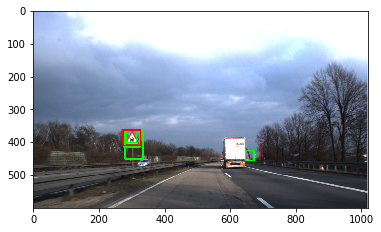

predicted sign:  4
predicted sign:  4
predicted sign:  4
ground truth sign:  4
ground truth sign:  4


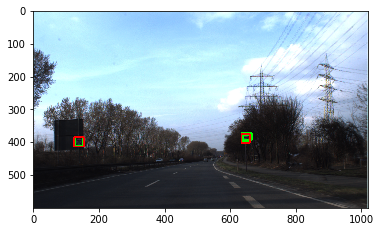

predicted sign:  6
ground truth sign:  42


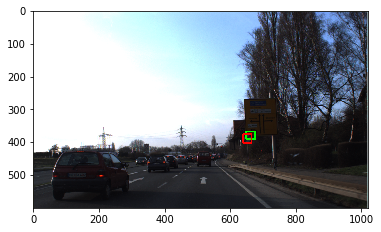

predicted sign:  24
ground truth sign:  24


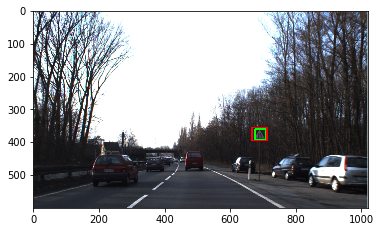

predicted sign:  12
ground truth sign:  12


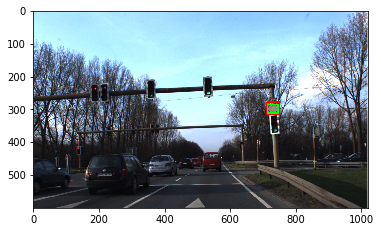

predicted sign:  4
predicted sign:  4
predicted sign:  4
predicted sign:  4
predicted sign:  4
ground truth sign:  4
ground truth sign:  4


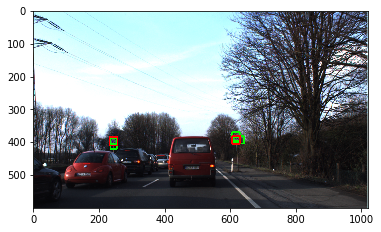

In [31]:
import matplotlib.pyplot as plt

# run some tests
i=0

number_of_images = 10

for filename in test_images:
    # Draw predictions
    aux = test_images.get(filename)[0].copy()
    for bbox in test_pred.get(filename)[0]:  
        
        #filter some boxes before making predictions
        dx = int(bbox[0])-int(bbox[2])
        dy = int(bbox[1])-int(bbox[3])
        ratio = abs(dy/dx)
        if ratio<1:
            ratio=1/ratio
        if ratio>2 or abs(dx)>96 or abs(dy)>96:
            continue
        
        # make a prediction
        roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        SIGN_SIZE_CNN = (96, 96)
        roi_resized = cv2.resize(roi, SIGN_SIZE_CNN)
        roi_resized = roi_resized.astype('float32')
        roi_resized /= 255.0
        roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE_CNN[0],SIGN_SIZE_CNN[1],3])
        
        confidence = tlm.predict(roi_resized)
        if max(confidence[0][0:len(confidence[0])-2])>=0.5:
        # if confidence[0][1] >= 0.5:
            # print(confidence[0][1])
            print("predicted sign: ", np.argmax(confidence[0]))
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)       
          

    if filename in test_files2:
        for idx in [i for i, x in enumerate(test_files2) if x == filename]:
            bbox = test_bboxes2[idx]
            print("ground truth sign: ", test_labels2[idx])
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,0,255), 3)           
            
    
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
    i+=1
    if i==number_of_images: break

In [32]:
# serialize model to JSON
model_json = tlm.to_json()
with open("drive/My Drive/models/bin_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
tlm.save_weights("drive/My Drive/models/bin_model.h5")
print("Saved model to disk")

Saved model to disk


## Prepare the dataset for retraining

In [0]:
with open('drive/My Drive/models/train_pred.pickle', 'rb') as fp:
    train_pred = pickle.load(fp)

In [0]:
"""Operations for [N, 4] numpy arrays representing bounding boxes.
Example box operations that are supported:
  * Areas: compute bounding box areas
  * IOU: pairwise intersection-over-union scores
"""
def area(boxes):
    """Computes area of boxes.
    Args:
    boxes: Numpy array with shape [N, 4] holding N boxes
    Returns:
    a numpy array with shape [N*1] representing box areas
    """
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def intersection(boxes1, boxes2):
    """Compute pairwise intersection areas between boxes.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes
    boxes2: a numpy array with shape [M, 4] holding M boxes
    Returns:
    a numpy array with shape [N*M] representing pairwise intersection area
    """
    [x_min1, y_min1, x_max1, y_max1] = np.split(boxes1, 4, axis=1)
    [x_min2, y_min2, x_max2, y_max2] = np.split(boxes2, 4, axis=1)
    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    intersect_heights = np.maximum(np.zeros(all_pairs_max_ymin.shape, dtype='f4'),all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    intersect_widths = np.maximum(np.zeros(all_pairs_max_xmin.shape, dtype='f4'),all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths

def iou(boxes1, boxes2):
    """Computes pairwise intersection-over-union between box collections.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding M boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise iou scores.
    """
    intersect = intersection(boxes1, boxes2)
    area1 = area(boxes1)
    area2 = area(boxes2)
    union = np.expand_dims(area1, axis=1) + np.expand_dims(area2, axis=0) - intersect
    return intersect / union

def ioa(boxes1, boxes2):
    """Computes pairwise intersection-over-area between box collections.
    Intersection-over-area (ioa) between two boxes box1 and box2 is defined as
    their intersection area over box2's area. Note that ioa is not symmetric,
    that is, IOA(box1, box2) != IOA(box2, box1).
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding N boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise ioa scores.
    """
    intersect = intersection(boxes1, boxes2)
    inv_areas = np.expand_dims(1.0 / area(boxes2), axis=0)
    return intersect * inv_areas

def clip_boxes(bboxes, clip_box, alpha):
    """
    This function clip the bboxes to the border of the image

    :param bboxes: array of shape (Nx4) containing the coordinates of the bboxes
                in the format: xmin, ymin, xmax, ymax.
    :param clip_box: array of shape (4,) containing the coordinates of the image
                in the format: xmin, ymin, xmax ymax.
    :param alpha:float, minimum threshold of area acepted. If a clipped bbpx
                    have an relative area (wrt their original area) less than
                    alpha, it is discarded.
    :return: numpy array Nx4 of the clipped bboxes with their new coordinates
            in the format xmin, ymin, xmax, ymax.
    """
    areas = area(bboxes)
    bboxes[:, 0] = np.maximum(bboxes[:, 0], clip_box[0])
    bboxes[:, 1] = np.maximum(bboxes[:, 1], clip_box[1])
    bboxes[:, 2] = np.minimum(bboxes[:, 2], clip_box[2])
    bboxes[:, 3] = np.minimum(bboxes[:, 3], clip_box[3])
    new_areas = area(bboxes)
    delta_area = (areas - new_areas) / areas
    mask = np.where(delta_area < 1 - alpha)
    bboxes = bboxes[mask[0]]
    return bboxes

In [0]:
# Get the wrong classified images for retraining. An image with confidence>=0.5 and IOU<0.2 is considered FP.
i=0

number_of_images = 600 # the dataset contains 600 training images
counter_0 = 0
counter_1 = 0

with open('drive/My Drive/data/bin_labels_retrain.txt', 'w+') as file:
  
  for filename in train_images:
      # Draw predictions
      # aux = train_images.get(filename)[0].copy()

      gr_bboxes = []
      gr_labels = []
      if filename in train_files2:
          for idx in [i for i, x in enumerate(train_files2) if x == filename]:
              gbbox = train_bboxes2[idx]
              gr_bboxes.append(gbbox)
              gr_labels.append(train_labels2[idx])
              file.write( 
                  filename.split('/')[-1]+';'+
                  str(int(gbbox[0]))+';'+
                  str(int(gbbox[1]))+';'+
                  str(int(gbbox[2]))+';'+
                  str(int(gbbox[3]))+';'+
                  str(train_labels2[idx]))
              file.write('\n')
              # cv2.rectangle(aux, (int(gbbox[0]),int(gbbox[1])), (int(gbbox[2]),int(gbbox[3])), (0,0,255), 3)

      for bbox in train_pred.get(filename)[0]:  
          
          #filter some boxes before making predictions
          dx = int(bbox[0])-int(bbox[2])
          dy = int(bbox[1])-int(bbox[3])
          ratio = abs(dy/dx)
          if ratio<1:
              ratio=1/ratio
          if ratio>2 or abs(dx)>96 or abs(dy)>96:
              continue

          temp = []
          for k in range(len(gr_bboxes)):
            iou_var = iou(np.array([gr_bboxes[k]]).astype('float32'), np.array([bbox]))
            temp.append(float(iou_var[0]))
          
          # make a prediction
          roi = train_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
          SIGN_SIZE_CNN = (96, 96)
          roi_resized = cv2.resize(roi, SIGN_SIZE_CNN)
          roi_resized = roi_resized.astype('float32')
          roi_resized /= 255.0
          roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE_CNN[0],SIGN_SIZE_CNN[1],3])
          
          confidence = tlm.predict(roi_resized)
          if max(confidence[0][0:len(confidence[0])-2])>=0.5 and max(temp, default=0)<0.2:
          # if confidence[0][1]>=0.5 and max(temp, default=0)<0.2:
              # print(confidence[0][1])
              file.write(
                  filename.split('/')[-1]+';'+
                  str(int(bbox[0]))+';'+
                  str(int(bbox[1]))+';'+
                  str(int(bbox[2]))+';'+
                  str(int(bbox[3]))+';-1')
              file.write('\n')
              counter_0+=1
              # cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)

          if max(temp, default=0)>=0.5:
              # print(confidence[0][1])
              sindex = temp.index(max(temp))
              slabel = gr_labels[sindex]
              file.write(
                  filename.split('/')[-1]+';'+
                  str(int(bbox[0]))+';'+
                  str(int(bbox[1]))+';'+
                  str(int(bbox[2]))+';'+
                  str(int(bbox[3]))+';'+
                  str(slabel))
              file.write('\n')
              counter_1+=1
              # cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)
      
      # plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
      # plt.show()
      i+=1
      print(i)
      if i==number_of_images: break


print(counter_0)
print(counter_1)

In [0]:
! sort 'drive/My Drive/data/bin_labels_retrain.txt' --output='drive/My Drive/data/bin_labels_retrain_sorted.txt'
! wc -l 'drive/My Drive/data/bin_labels_retrain_sorted.txt'
! head -n 10 'drive/My Drive/data/bin_labels_retrain_sorted.txt'
! tail -n 10 'drive/My Drive/data/bin_labels_retrain_sorted.txt'

In [0]:
# this is just to  get numbers for traffic signs range in train and test set
! wc -l 'drive/My Drive/data/bin_labels_retrain_sorted.txt'
! grep "00599.ppm" -B 5 -A 5 -m 1 'drive/My Drive/data/bin_labels_retrain_sorted.txt' --line-number